# Test
**FaceNet** &ensp;&ensp;vs&ensp;&ensp;**ResNet18 easy**

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as tf
import matplotlib.pyplot as plt
from torch.autograd import Variable
import pandas as pd
import seaborn as sns
from math import sqrt
from PIL import Image
from torch.nn import functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
import time
import os
import math
import copy
import json
import random

## ResNet18

In [2]:
# ResNet with available versions: 18, 34, 50, 101,152

# block for small version of resnet
class Block_s(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(Block_s,self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn2   = nn.BatchNorm2d(out_planes)
        self.downsample = downsample
        
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out
    
# block for large version of resnet
class Block_l(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(Block_l,self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)  
        self.bn2   = nn.BatchNorm2d(out_planes)
        self.conv3 = nn.Conv2d(out_planes, out_planes*4, kernel_size=1, stride=1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_planes*4)
        self.relu  = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out
        
        
class Resnet(nn.Module):
    def __init__(self, version=18, num_classes=128):
        self.v = version
        self.v_dic = {18:[2,2,2,2,512], 34:[3,4,6,3,512], 50:[3,4,6,3,2048], 101:[3,4,23,3,2048], 152:[3,8,36,3,2048]}
        self.in_planes = 64
        
        super(Resnet,self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.conv2_x = self.make_layers(self.v_dic[version][0], stride=1, planes=64)
        self.conv3_x = self.make_layers(self.v_dic[version][1], stride=2, planes=128)
        self.conv4_x = self.make_layers(self.v_dic[version][2], stride=2, planes=256)
        self.conv5_x = self.make_layers(self.v_dic[version][3], stride=2, planes=512)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(self.v_dic[version][4], num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def make_layers(self, repeat_times, stride, planes):
        if self.v < 50:
            downsample = None
            if stride!=1:
                downsample = nn.Sequential(
                    nn.Conv2d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes)
                )
            layers=[]
            layers.append(Block_s(self.in_planes, planes, stride, downsample))
            self.in_planes = planes
            for i in range(repeat_times-1):
                layers.append(Block_s(self.in_planes, planes))
            return nn.Sequential(*layers)
            
        else:
            downsample = nn.Sequential(
                    nn.Conv2d(self.in_planes, planes*4,kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes*4)
            )
            layers=[]
            layers.append(Block_l(self.in_planes, planes, stride, downsample))
            self.in_planes = planes*4
            for i in range(repeat_times-1):
                layers.append(Block_l(self.in_planes, planes))
            return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxPool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x =self.fc(x)
        
        return x

## FaceNet

In [3]:
class FaceNet(nn.Module):
    def __init__(self):
        super(FaceNet, self).__init__()

        self.model = models.resnet18()
        self.model.fc = nn.Linear(25088, 128)

    def l2_norm(self,input):
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        _output = torch.div(input, norm.view(-1, 1).expand_as(input))
        output = _output.view(input_size)
        return output

    
    def forward(self, x):

        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)
        self.features = self.l2_norm(x)
        self.features = self.features * 10

        return self.features

## Test Dataset
This dataset reads the pairsDevTest.txt and the models will determine whether the pairs given by the dataset are images of the same person. As for the ground truth, label = 1 if yes and 0 if no.

In [4]:
class Testset(data.Dataset):
    
    def __init__(self):
        
        self.root = '../input/lfwaligned/test2/test2'
        self.result = []
        
        file = open('../input/lfwaligned/pairsDevTest.txt')
        lines = file.readlines()

        for count,line in enumerate(lines):

            line = line.strip().split()
            
            if len(line)==1:
                continue
                
            elif len(line)==3:
                label = 1
                img, id1, id2 = line
                img1 = img + '_' + ('000'+ id1)[-4:] + '.jpg'
                img2 = img + '_' + ('000'+ id2)[-4:] + '.jpg'
                
            elif len(line)==4:
                label = 0
                img1, id1, img2, id2 = line
                img1 = img1 + '_' + ('000'+ id1)[-4:] + '.jpg'
                img2 = img2 + '_' + ('000'+ id2)[-4:] + '.jpg'
  
            self.result.append([img1,img2,label])
        
        
    def __getitem__(self, index):
        
        img1, img2, label = self.result[index]
        
        img1 = Image.open(os.path.join(self.root,img1))
        img1 = tf.resize(img1, (224,224))
        img1 = tf.to_tensor(img1)
        img1 = tf.normalize(img1, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        img1 = img1.expand(1,3,224,224)
        
        img2 = Image.open(os.path.join(self.root,img2))
        img2 = tf.resize(img2, (224,224))
        img2 = tf.to_tensor(img2)
        img2 = tf.normalize(img2, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        img2 = img2.expand(1,3,224,224)
        
        return img1, img2, label
   

    def __len__(self):
        return len(self.result)

In [5]:
import operator
from sklearn.model_selection import KFold
from scipy import interpolate

def evaluate(distances, labels, nrof_folds=10):
    thresholds=np.arange(0, 30, 0.01)
    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=True)

    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, distances[train_set], labels[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _ = calculate_accuracy(threshold, distances[test_set], labels[test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], distances[test_set], labels[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
    accuracy = np.mean(accuracy)
    return tpr, fpr, accuracy, thresholds[best_threshold_index]


def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc

In [6]:
def plot_roc(fpr,tpr):
    fig = plt.figure(figsize=(4.8,4.8))
    lw = 2
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='test ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

In [7]:
def L2_distance(x1,x2):
    assert x1.size() == x2.size()
    eps = 1e-4 / x1.size(1)
    diff = torch.abs(x1 - x2)
    out = torch.pow(diff, 2).sum(dim=1)
    return torch.pow(out + eps, 1./2).item()

# def test_model(model, threshold, trace = False):
def test_model(model):
    model.eval()
    distances = []
    labels = []
#     falses = []
    for i in range(len(testset)):
        if i%200==0:
            print('working on ' + str(i))
        img1, img2, label = testset[i]
        labels.append(label)
        img1, img2 = img1.to(device), img2.to(device)
        out1, out2 = model(img1), model(img2)
        dist = L2_distance(out1,out2)
#         pred = (dist < threshold)
#         if pred != label:
#             falses.append(i)
        distances.append(dist)

    tpr, fpr, acc, threshold = evaluate(np.array(distances),np.array(labels))
    print('test accuracy: {:.4f} threshold: {:.4f}'.format(acc, threshold))
#     if trace:
#         return falses, distances, labels, tpr, fpr
    return distances, labels, tpr, fpr

Here are the FaceNet and ResNet18 finalized.

In [8]:
device = torch.device('cuda:0')

testset = Testset()

model1 = FaceNet().to(device)
model1.load_state_dict(torch.load('../input/lfwaligned/FN.pth'))

model2 = Resnet().to(device)
model2.load_state_dict(torch.load('../input/lfwaligned/RN_easy.pth'))

<All keys matched successfully>

## Test and plot

In [9]:
distances1, labels1, tpr1, fpr1 = test_model(model1)

working on 0
working on 200
working on 400
working on 600
working on 800
test accuracy: 0.7350 threshold: 3.9100


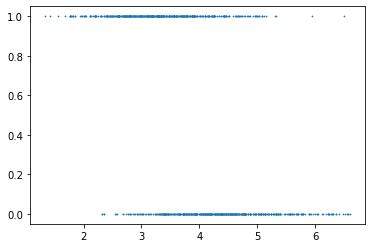

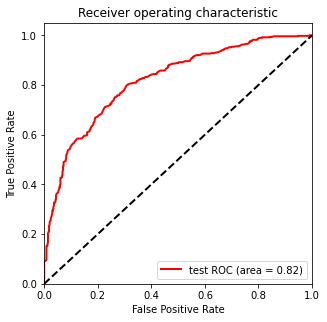

In [10]:
plt.scatter(distances1,labels1,s=0.5);
plot_roc(fpr1,tpr1);

In [11]:
distances2, labels2, tpr2, fpr2 = test_model(model2)

working on 0
working on 200
working on 400
working on 600
working on 800
test accuracy: 0.7370 threshold: 2.5100


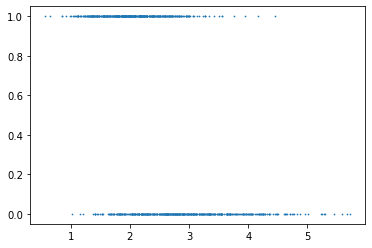

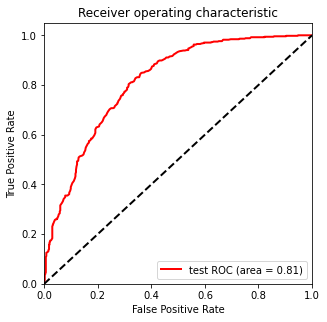

In [12]:
plt.scatter(distances2,labels2,s=0.5);
plot_roc(fpr2,tpr2);

In [13]:
statistics = {'embedding':[distances1, labels1, list(tpr1),list(fpr1)],'classifier':[distances2, labels2, list(tpr2),list(fpr2)]}
json.dump(statistics, open('compare.json', 'w'))